<a href="https://colab.research.google.com/github/coco-in-bluemoon/three-minute-deep-learning-keras/blob/main/notebook/chapter8_1_unet_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**UNET 모델링**


In [1]:
from keras import backend
from keras import layers, models

In [2]:
class UNET(models.Model):
    def __init__(self, org_shape, n_ch):
        ic = 3 if backend.image_data_format() == 'channels_last' else 1

        def conv(x, n_f, mp_flag=True):
            x = layers.MaxPooling2D((2, 2), padding='same')(x) if mp_flag else x
            x = layers.Conv2D(n_f, (3, 3), padding='same')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation('tanh')(x)
            x = layers.Dropout(0.05)(x)
            x = layers.Conv2D(n_f, (3, 3), padding='same')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation('tanh')(x)

            return x

        def deconv_unet(x, e, n_f):
            x = layers.UpSampling2D((2, 2))(x)
            x = layers.Concatenate(axis=ic)([x, e])
            x = layers.Conv2D(n_f, (3, 3), padding='same')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation('tanh')(x)
            x = layers.Conv2D(n_f, (3, 3), padding='same')(x)
            x = layers.BatchNormalization()(x)
            x = layers.Activation('tanh')(x)

            return x

        original = layers.Input(shape=org_shape)

        c1 = conv(original, 16, mp_flag=False)
        c2 = conv(c1, 32)

        encoded = conv(c2, 64)

        x = deconv_unet(encoded, c2, 32)
        x = deconv_unet(x, c1, 16)

        decoded = layers.Conv2D(n_ch, (3, 3), activation='sigmoid', padding='same')(x)

        super(UNET, self).__init__(original, decoded)
        self.compile(
            loss='mse',
            optimizer='adam'
        )

**데이터 준비**

In [3]:
from keras import datasets
from keras import utils

In [4]:
class Data:
    def __init__(self, in_ch=None):
        (x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

        if x_train.ndim == 4:
            if backend.image_data_format() == 'channels_first':
                n_ch, img_rows, img_cols = x_train.shape[1:]
            else:
                img_rows, img_cols, n_ch = x_train.shape[1:]
        else:
            img_rows, img_cols = x_train.shape[1:]
            n_ch = 1

        in_ch = n_ch if in_ch is None else in_ch

        x_train = x_train.astype('float32') / 255.
        x_test = x_test.astype('float32') / 255.

        def RGB2Gray(X, fmt):
            if fmt == 'channels_first':
                R = X[:, 0:1]
                G = X[:, 1:2]
                B = X[:, 2:3]
            else:
                R = X[..., 0:1]
                G = X[..., 1:2]
                B = X[..., 2:3]

            return 0.299*R + 0.587*G + 0.114*B

        def RGB2RG(x_train_out, x_test_out, fmt):
            if fmt == 'channels_first':
                x_train_in = x_train_out[:, :2]
                x_test_in = x_test_out[:, :2]
            else:
                x_train_in = x_train_out[..., :2]
                x_test_in = x_test_out[..., :2]
            return x_train_in, x_test_in

        if backend.image_data_format() == 'channels_first':
            x_train_out = x_train.reshape(x_train.shape[0], n_ch, img_rows, img_cols)
            x_test_out = x_test.reshape(x_test.shape[0], n_ch, img_rows, img_cols)
            input_shape = (in_ch, img_rows, img_cols)
        else:
            x_train_out = x_train.reshape(x_train.shape[0], img_rows, img_cols, n_ch)
            x_test_out = x_test.reshape(x_test.shape[0], img_rows, img_cols, n_ch)
            input_shape = (img_rows, img_cols, in_ch)

        if in_ch == 1 and n_ch == 3:
            x_train_in = RGB2Gray(x_train_out, backend.image_data_format())
            x_test_in = RGB2Gray(x_test_out, backend.image_data_format())
        elif in_ch == 2 and n_ch == 3:
            x_train_in, x_test_in = RGB2RG(x_train_out, x_test_out, backend.image_data_format())
        else:
            x_train_in = x_train_out
            x_test_in = x_test_out

        self.input_shape = input_shape
        self.x_train_in, self.x_train_out = x_train_in, x_train_out
        self.x_test_in, self.x_test_out = x_test_in, x_test_out
        self.n_ch = n_ch
        self.in_ch = in_ch

In [5]:
%matplotlib inline

In [6]:
import matplotlib.pyplot as plt
import numpy as np

In [7]:
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Trian', 'Test'], loc=0)

def show_images(data, unet):
    x_test_in = data.x_test_in
    x_test_out = data.x_test_out
    decoded_imgs = unet.predict(x_test_in)

    if backend.image_data_format() == 'channels_first':
        print(x_test_out.shape)
        x_test_out = x_test_out.swapaxes(1, 3).swapaxes(1, 2)
        print(x_test_out.shape)
        decoded_imgs = decoded_imgs.swapaxes(1, 3).swapaxes(1, 2)
        if data.in_ch == 1:
            x_test_in = x_test_in[:, 0, ...]
        elif data.in_ch == 2:
            print(x_test_out.shape)
            x_test_in_tmp = np.zeros_like(x_test_out)
            x_test_in = x_test_in.swapaxes(1, 3).swapaxes(1, 2)
            x_test_in_tmp[..., :2] = x_test_in
            x_test_in = x_test_in_tmp
        else:
            x_test_in = x_test_in.swapaxes(1, 3).swapaxes(1, 2)
    else:
        if data.in_ch == 1:
            x_test_in = x_test_in[..., 0]
        elif data.in_ch == 2:
            x_test_in_tmp = np.zeros_like(x_test_out)
            x_test_in_tmp[..., :2] = x_test_in
            x_test_in = x_test_in_tmp

    n = 10
    plt.figure(figsize=(20, 6))
    for i in range(n):
        ax = plt.subplot(3, n, i+1)
        plt.imshow(x_test_in[i].reshape(32, 32), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i+1+n)
        plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i+1+n+n)
        plt.imshow(x_test_out[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [8]:
def main(in_ch=1, epochs=10, batch_size=128, fig=True):
    data = Data(in_ch=in_ch)
    unet = UNET(data.input_shape, data.n_ch)

    history = unet.fit(data.x_train_in, data.x_train_out,
                       epochs=epochs, batch_size=batch_size,
                       shuffle=True, validation_split=0.2)
    if fig:
        plot_loss(history)
        show_images(data, unet)

Epoch 1/10
313/313 [==============================] - 16s 52ms/step - loss: 0.0102 - val_loss: 0.0360
Epoch 2/10
313/313 [==============================] - 15s 49ms/step - loss: 0.0070 - val_loss: 0.0163
Epoch 3/10
313/313 [==============================] - 15s 49ms/step - loss: 0.0065 - val_loss: 0.0078
Epoch 4/10
313/313 [==============================] - 15s 49ms/step - loss: 0.0062 - val_loss: 0.0063
Epoch 5/10
313/313 [==============================] - 15s 49ms/step - loss: 0.0061 - val_loss: 0.0076
Epoch 6/10
313/313 [==============================] - 15s 49ms/step - loss: 0.0060 - val_loss: 0.0062
Epoch 7/10
313/313 [==============================] - 15s 49ms/step - loss: 0.0059 - val_loss: 0.0067
Epoch 8/10
313/313 [==============================] - 15s 49ms/step - loss: 0.0058 - val_loss: 0.0060
Epoch 9/10
313/313 [==============================] - 15s 49ms/step - loss: 0.0058 - val_loss: 0.0056
Epoch 10/10
313/313 [==============================] - 15s 49ms/step - loss: 0.005

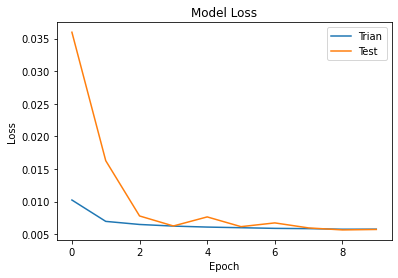

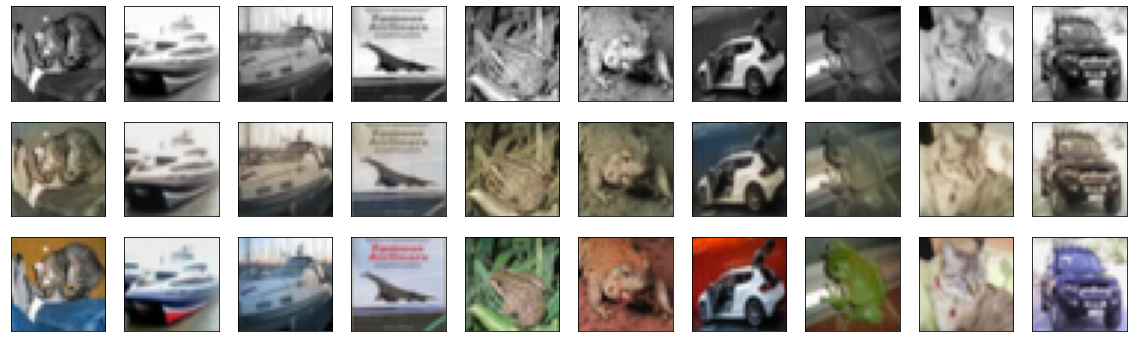

In [9]:
main()